In [1]:
%matplotlib inline
from matplotlib.colors import PowerNorm, LogNorm
import numpy as np
import os
import pandas as pd
%load_ext autoreload
%autoreload 2

import palm_diagnostics as pdiag

In [2]:
pdiag.pb.register()

In [3]:
@pdiag.dask.delayed
def _gen_img_sub_thread(chunklen, chunk, yx_shape, df, mag, multipliers, diffraction_limit):
    """"""
    s = slice(chunk * chunklen, (chunk + 1) * chunklen)
    df_chunk = df[["y0", "x0", "sigma_y", "sigma_x"]].values[s]
    # calculate the amplitude of the z gaussian.
    amps = multipliers[s]
    # generate a 2D image weighted by the z gaussian.
    print(amps)
    return pdiag._jit_gen_img_sub(yx_shape, df_chunk, mag, amps, diffraction_limit)


def _gen_img_sub_threaded(yx_shape, df, mag, multipliers, diffraction_limit, numthreads=1):
    """"""
    length = len(df)
    chunklen = (length + numthreads - 1) // numthreads
    new_shape = tuple(np.array(yx_shape) * mag)
    # print(dask.array.from_delayed(_gen_zplane(df, yx_shape, zplanes[0], mag), new_shape, np.float))
    rendered_threads = [pdiag.dask.array.from_delayed(
        _gen_img_sub_thread(chunklen, chunk, yx_shape, df, mag, multipliers, diffraction_limit), new_shape, np.float)
                        for chunk in range(numthreads)]
    lazy_result = pdiag.dask.array.stack(rendered_threads)
    return lazy_result.sum(0)

In [4]:
def _gen_img_sub_threaded2(yx_shape, df, mag, multipliers, diffraction_limit, numthreads=1):
    new_shape = np.array(yx_shape) * mag
    keys_for_render = ["y0", "x0", "sigma_y", "sigma_x"]
    df = df[keys_for_render].values
    length = len(df)
    chunklen = (length + numthreads - 1) // numthreads
    
    delayed_jit_gen_img_sub = pdiag.dask.delayed(pdiag._jit_gen_img_sub)
    print([multipliers[i * chunklen:(i + 1) * chunklen]
                               for i in range(numthreads)])
    lazy_result = [delayed_jit_gen_img_sub(yx_shape, df[i * chunklen:(i + 1) * chunklen], mag,
                                           multipliers[i * chunklen:(i + 1) * chunklen], diffraction_limit)
                               for i in range(numthreads)]
    
    lazy_result = pdiag.dask.array.stack([pdiag.dask.array.from_delayed(l, new_shape, np.float)
        for l in lazy_result])
    
    return lazy_result.sum(0)

In [5]:
test_data = pd.DataFrame((np.random.rand(50000000,4)), columns=["y0", "x0", "sigma_y", "sigma_x"])
test_data[["sigma_y", "sigma_x"]] *= 0.01
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000000 entries, 0 to 49999999
Data columns (total 4 columns):
y0         float64
x0         float64
sigma_y    float64
sigma_x    float64
dtypes: float64(4)
memory usage: 1.5 GB


In [6]:
from dask.dot import dot_graph

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
CPU times: user 563 ms, sys: 468 ms, total: 1.03 s
Wall time: 1.03 s


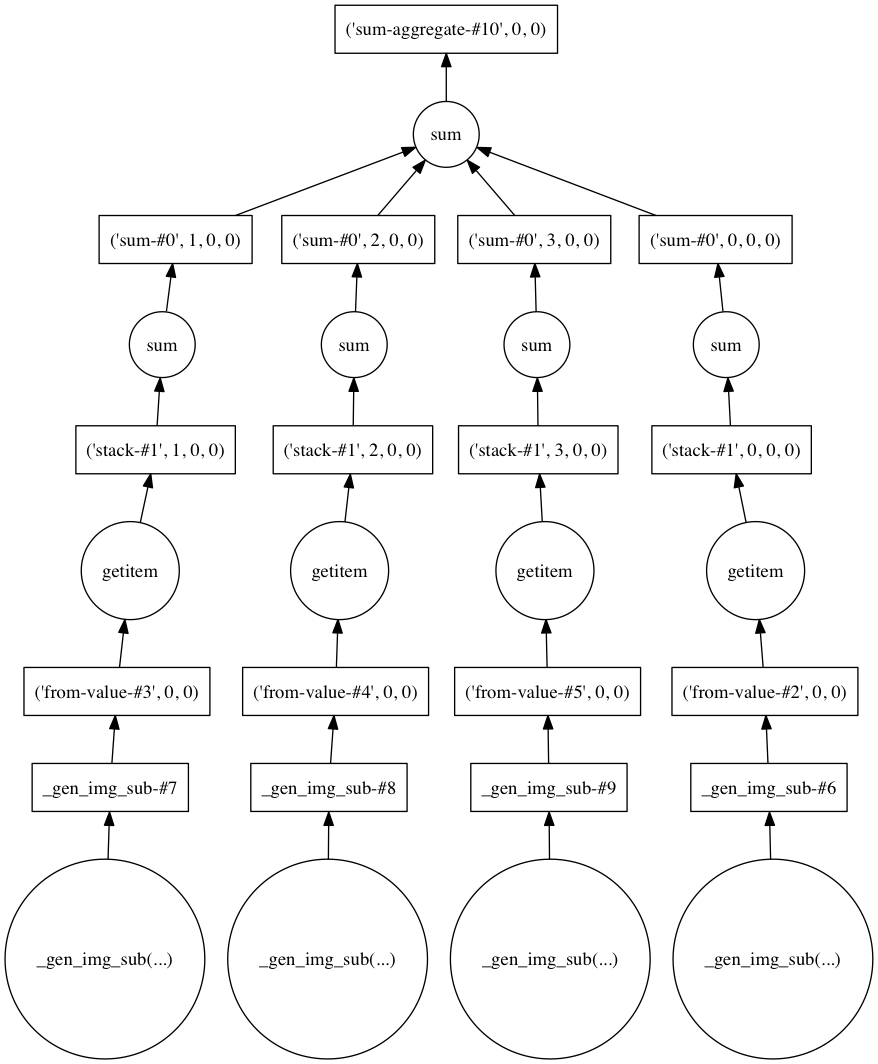

In [7]:
%time timg = _gen_img_sub_threaded2((1,1), test_data, 1, np.array(()), True, 4)
dot_graph(timg.dask)

In [8]:
%time timg = _gen_img_sub_threaded((1,1), test_data, 1000, np.array(()), True, 1)
%time a = timg.compute()

CPU times: user 1.47 ms, sys: 326 µs, total: 1.8 ms
Wall time: 1.8 ms
[                                        ] | 0% Completed |  1.1s[]
[########################################] | 100% Completed | 15min  7.6s
CPU times: user 14min 59s, sys: 19.3 s, total: 15min 18s
Wall time: 15min 7s


In [9]:
%time timg = _gen_img_sub_threaded((1,1), test_data, 1000, np.array(()), True, 2)
%time a = timg.compute()

CPU times: user 1.38 ms, sys: 150 µs, total: 1.53 ms
Wall time: 1.52 ms
[                                        ] | 0% Completed |  1.7s[]
[]
[########################################] | 100% Completed |  8min 22.6s
CPU times: user 16min 28s, sys: 16.9 s, total: 16min 45s
Wall time: 8min 22s


In [10]:
%time timg = _gen_img_sub_threaded((1,1), test_data, 1000, np.array(()), True, 4)
%time a = timg.compute()

CPU times: user 1.43 ms, sys: 55 µs, total: 1.49 ms
Wall time: 1.46 ms
[                                        ] | 0% Completed |  1.0s[][]

[                                        ] | 0% Completed |  3.8s[]
[]
[########################################] | 100% Completed |  6min  4.0s
CPU times: user 22min 42s, sys: 22.3 s, total: 23min 5s
Wall time: 6min 3s


In [11]:
%time timg = _gen_img_sub_threaded((1,1), test_data, 1000, np.array(()), True, 4)
%time a = timg.compute(get=pdiag.dask.multiprocessing.get)

CPU times: user 2.61 ms, sys: 2.56 ms, total: 5.17 ms
Wall time: 5.16 ms
[                                        ] | 0% Completed |  9.5s[]
[                                        ] | 0% Completed | 52.7s[]
[                                        ] | 0% Completed |  1min 36.8s[]
[                                        ] | 0% Completed |  2min 19.6s[]
[########################################] | 100% Completed |  7min 60.0s
CPU times: user 25.8 s, sys: 1min 6s, total: 1min 32s
Wall time: 8min


# Original way

In [12]:
%time timg = _gen_img_sub_threaded2((1,1), test_data, 1000, np.array(()), True, 1)
%time a = timg.compute()

[array([], dtype=float64)]
CPU times: user 875 ms, sys: 2.72 s, total: 3.6 s
Wall time: 7.1 s
[########################################] | 100% Completed | 15min 16.8s
CPU times: user 15min 11s, sys: 17.4 s, total: 15min 28s
Wall time: 15min 16s


In [13]:
%time timg = _gen_img_sub_threaded2((1,1), test_data, 1000, np.array(()), True, 4)
%time a = timg.compute()

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
CPU times: user 670 ms, sys: 741 ms, total: 1.41 s
Wall time: 1.61 s
[########################################] | 100% Completed |  5min 45.1s
CPU times: user 22min 27s, sys: 13.2 s, total: 22min 40s
Wall time: 5min 45s


In [14]:
%time timg = _gen_img_sub_threaded2((1,1), test_data, 1000, np.array(()), True, 4)
%time a = timg.compute(get=pdiag.dask.multiprocessing.get)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
CPU times: user 561 ms, sys: 616 ms, total: 1.18 s
Wall time: 1.36 s
[########################################] | 100% Completed |  5min 58.6s
CPU times: user 9.41 s, sys: 12.2 s, total: 21.6 s
Wall time: 5min 58s
